In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pathlib
import os

from helper_functions import *
metadata = pd.read_csv("metadata.csv")
metadata_cfdna = metadata[metadata["Sample type"].isin(["cfDNA", "Control"])]
import warnings
warnings.filterwarnings("ignore")
import random
outputdir = "./outputdir_02102023"

topK = 500
atlas_sample_types = "Tissue,WBC"

In [11]:
ichorcnadf = pd.read_csv(os.path.join(outputdir, "Loyfer_UXM_deconvolution", "summary_tumor_fraction_original.csv"))

loyferdf = pd.read_csv(os.path.join(outputdir, "Loyfer_UXM_deconvolution", "cfDNA_highdepth.csv"))

loyferdf = loyferdf.set_index("CellType").T.reset_index()
loyferdf.columns

Index(['index', 'Adipocytes', 'Bladder-Ep', 'Blood-B', 'Blood-Granul',
       'Blood-Mono+Macro', 'Blood-NK', 'Blood-T', 'Breast-Basal-Ep',
       'Breast-Luminal-Ep', 'Colon-Ep', 'Endothel', 'Epid-Kerat', 'Eryth-prog',
       'Fallopian-Ep', 'Gastric-Ep', 'Head-Neck-Ep', 'Heart-Cardio',
       'Heart-Fibro', 'Kidney-Ep', 'Liver-Hep', 'Lung-Ep-Alveo',
       'Lung-Ep-Bron', 'Neuron', 'Oligodend', 'Ovary-Ep', 'Pancreas-Acinar',
       'Pancreas-Alpha', 'Pancreas-Beta', 'Pancreas-Delta', 'Pancreas-Duct',
       'Megakaryocytes', 'Prostate-Ep', 'Skeletal-Musc', 'Small-Int-Ep',
       'Smooth-Musc', 'Thyroid-Ep'],
      dtype='object', name='CellType')

In [8]:

wbc_cell_types = [item for item in loyferdf.columns if "Blood" in item] + ["Megakaryocytes"]
loyferdf["WBC_Loyfer"] = loyferdf[wbc_cell_types].apply(lambda x: sum(x), axis = 1)
loyferdf = loyferdf.drop(wbc_cell_types, axis = 1)
loyferdf.columns = ["Sample"] + list(loyferdf.columns[1:])


In [9]:
wbc_cell_types

['Blood-B',
 'Blood-Granul',
 'Blood-Mono+Macro',
 'Blood-NK',
 'Blood-T',
 'Megakaryocytes']

In [3]:
df = pd.read_csv(os.path.join(outputdir, "Loyfer_UXM_deconvolution", "deconvo_by_{}_{}.csv".format(
    topK, atlas_sample_types
)), index_col = [0]).drop("spike_in_rate", axis = 1)



In [4]:
loyferdf["Sample"] = loyferdf["Sample"].apply(lambda x: x.split(".deduplicated")[0])

In [5]:
loyferdf[loyferdf["Sample"].str.contains("NB34")][ ["Sample"] + [item for item in loyferdf.columns if "Breast" in item]]

,Sample,Breast-Basal-Ep,Breast-Luminal-Ep
24,2-ZNB34R3W_M577-M777,0.000000,0.011029
53,NB34I0W,0.000000,0.000000
54,NB34I1W,0.000000,0.005071
55,NB34I2W,0.000000,0.014507
56,NB34I3W,0.003490,0.022988
57,NB34I4W,0.006927,0.096583


In [6]:
df[df["Sample"].str.contains("NB34")][ ["Sample"] + [item for item in df.columns if "Breast" in item]]

,Sample,Breast
0,NB34I1W,0.000000
1,NB34I2W,0.000000
2,NB34I3W,0.096276
3,NB34I4W,0.314404
12,2-ZNB34R3W_M577-M777,0.006826
2,NB34I0W,0.000000


In [7]:
df["tumor_fraction_ichorCNA"] = df["Sample"].apply(
    lambda x: ichorcnadf[ichorcnadf["Sample"] == x]["tumor_fraction_ichorCNA"].unique()[0])

In [8]:
df_cancer = df[(df["Label"] != "Control") & (df["Label"].isna() == False)]

In [9]:
clfdf = df_cancer[["Sample", "Liver", "Breast", "Gastric", "Lung", "CRC", "Label", "tumor_fraction_ichorCNA"]].copy()
convert_labels = dict()
convert_labels["Liver"] = 0
convert_labels["Breast"] = 1
convert_labels["Gastric"] = 2
convert_labels["Lung"] = 3
convert_labels["CRC"] = 4

convert_preds = dict()
convert_preds[0] = "Liver"
convert_preds[1] = "Breast"
convert_preds[2] = "Gastric"
convert_preds[3] = "Lung"
convert_preds[4] = "CRC"

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

labels = [convert_labels[item] for item in clfdf.Label.to_list()]
clfdf["num_Label"] = labels

preds = []
for sampleid in clfdf.Sample.unique():
    X_train = clfdf[clfdf["Sample"] != sampleid][["Liver", "Breast", "Gastric", "Lung", "CRC"]].to_numpy()
    y_train = clfdf[clfdf["Sample"] != sampleid]["num_Label"].to_numpy()
    X_test = clfdf[clfdf["Sample"] == sampleid][["Liver", "Breast", "Gastric", "Lung", "CRC"]].to_numpy()
    y_test = clfdf[clfdf["Sample"] == sampleid]["num_Label"].to_numpy()
    bst = XGBClassifier(n_estimators=100, max_depth=100, learning_rate=0.001, objective='multi:softmax')
    bst.fit(X_train, y_train)
    preds.append(bst.predict(X_test)[0])
predictiondf = pd.DataFrame(data = clfdf.Sample.to_list(), columns = ["Sample"])
predictiondf["preds"] = [convert_preds[item] for item in preds]
predictiondf["Label"] = clfdf["Label"].to_list()
predictiondf["tumor_fraction_ichorCNA"] = clfdf["tumor_fraction_ichorCNA"].to_list()
predictiondf["check"] = predictiondf[["preds", "Label"]].apply(lambda x: "yes" if x[0] == x[1] else "no", axis = 1)


In [10]:
df[df["tumor_fraction_ichorCNA"] != 0]

,Sample,Liver,Breast,Gastric,Lung,CRC,WBC,Label,prediction,check,depth,tumor_fraction_ichorCNA
3,NB34I4W,0.000000,0.314404,0.091547,0.037184,0.000000,0.556866,Breast,Breast,yes,5.734871,0.10550
6,37-ZNB27R3ME131W_M527-M727,0.037411,0.021712,0.060288,0.000700,0.000000,0.879889,Breast,Gastric,no,8.112809,0.08338
7,4-ZMH059R2ME131W_M509-M709,0.339071,0.000000,0.058070,0.022413,0.000000,0.580446,Liver,Liver,yes,15.967428,0.18150
8,5-ZNL09R2ME131W_M510-M710,0.056794,0.000000,0.056357,0.050715,0.000000,0.836135,Lung,Liver,no,14.785897,0.08472
9,4-ZMC061ME131W_M507-M707,0.218892,0.000000,0.105757,0.072450,0.010896,0.592005,CRC,Liver,no,14.786604,0.04458
23,37-ZNB20R1ME131W_M556-M756,0.495892,0.020669,0.008507,0.084903,0.000000,0.390029,Breast,Liver,no,4.420482,0.08250
25,33-ZMH057R1ME131W_S7523-S7723,0.159282,0.000000,0.045665,0.025007,0.001576,0.768470,Liver,Liver,yes,13.228937,0.08376
28,37-ZNB20R2ME131W_M556-M756,0.448305,0.065758,0.043956,0.027793,0.000000,0.414188,Breast,Liver,no,5.363689,0.08330
30,1-ZMH038ME131W_M549-M749,0.291111,0.010280,0.041680,0.057844,0.000000,0.599084,Liver,Liver,yes,10.018037,0.15820
32,1-ZMH046ME131W_M552-M752,0.353410,0.038052,0.041471,0.044895,0.000000,0.522172,Liver,Liver,yes,3.925074,0.15830


In [11]:
df[df["tumor_fraction_ichorCNA"] == 0]

,Sample,Liver,Breast,Gastric,Lung,CRC,WBC,Label,prediction,check,depth,tumor_fraction_ichorCNA
0,NB34I1W,0.045858,0.000000,0.088385,0.000000,0.000000,0.865756,Breast,Gastric,no,7.895823,0.0
1,NB34I2W,0.022112,0.000000,0.055797,0.011398,0.000000,0.910694,Breast,Gastric,no,10.201980,0.0
2,NB34I3W,0.041466,0.096276,0.059234,0.007661,0.012902,0.782460,Breast,Breast,yes,6.989186,0.0
4,35-ZNB12R3ME131W_M525-M725,0.049058,0.000000,0.076227,0.000000,0.000000,0.874716,Breast,Gastric,no,7.231751,0.0
5,36-ZNB22ME131W_M526-M726,0.050329,0.000000,0.041005,0.000000,0.000000,0.908666,Breast,Liver,no,9.659399,0.0
10,5-ZMC069ME131W_M508-M708,0.005887,0.000000,0.049414,0.003517,0.000000,0.941182,Gastric,Gastric,yes,16.376209,0.0
11,1-ZNB28R3W_M576-M776,0.068161,0.006513,0.034943,0.000000,0.000000,0.890383,Breast,Liver,no,1.497710,0.0
12,2-ZNB34R3W_M577-M777,0.056345,0.006826,0.051558,0.026932,0.000000,0.858339,Breast,Liver,no,7.641116,0.0
13,3-ZNB44W_M578-M778,0.015526,0.000000,0.049115,0.018494,0.000000,0.916864,Breast,Gastric,no,4.292338,0.0
14,4-ZMC063R3W_M579-M779,0.062827,0.000000,0.053498,0.000000,0.000000,0.883675,CRC,Liver,no,2.551182,0.0


<Axes: >

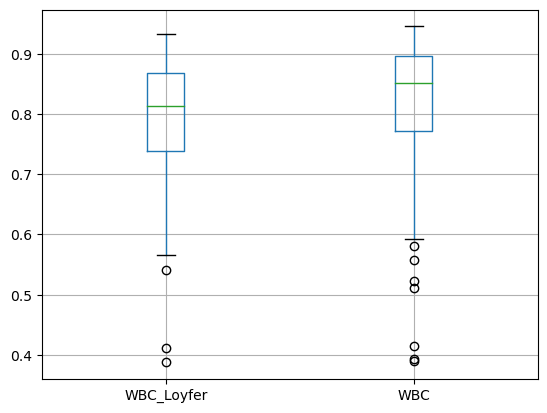

In [14]:
joindf = loyferdf.merge(df, right_on = "Sample", left_on = "Sample")

joindf[["WBC_Loyfer", "WBC"]].boxplot()

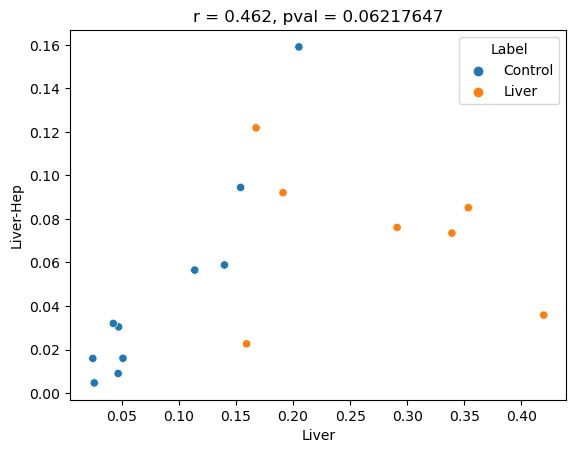

In [83]:
import scipy
group1 = "Liver"
group2 = "Liver-Hep"
x = joindf[joindf["Label"].isin(["Control", group1])][group1].to_numpy()
y = joindf[joindf["Label"].isin(["Control", group1])][group2].to_numpy()
r = scipy.stats.pearsonr(x, y)

sns.scatterplot(data = joindf[joindf["Label"].isin(["Control", group1])], x = group1, y = group2, hue = "Label")
plt.title("r = {:.3f}, pval = {:.8f}".format(r.correlation, r.pvalue))
plt.show()

In [76]:
joindf = joindf.fillna("Control")

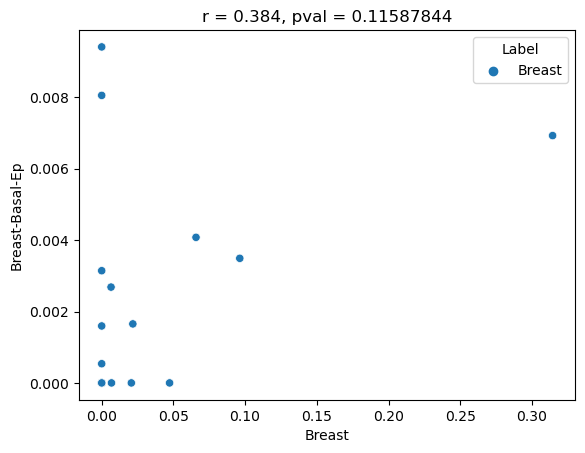

In [79]:
group1 = "Breast"
group2 = "Breast-Basal-Ep"
x = joindf[joindf["Label"] == group1][group1].to_numpy()
y = joindf[joindf["Label"] == group1][group2].to_numpy()
r = scipy.stats.pearsonr(x, y)

sns.scatterplot(data = joindf[joindf["Label"] == group1], x = group1, y = group2, hue = "Label")
plt.title("r = {:.3f}, pval = {:.8f}".format(r.correlation, r.pvalue))
plt.show()

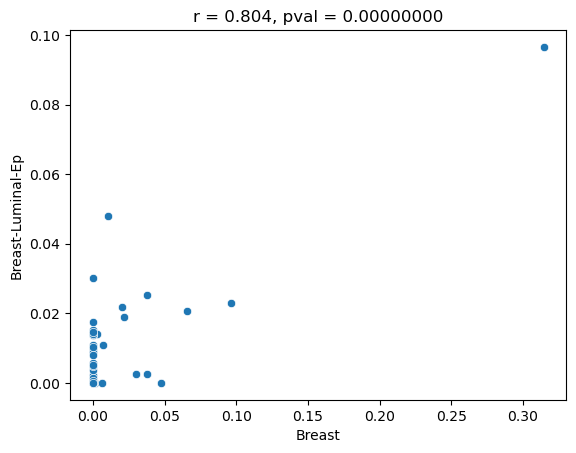

In [66]:
group1 = "Breast"
group2 = "Breast-Luminal-Ep"
x = joindf[group1].to_numpy()
y = joindf[group2].to_numpy()
r = scipy.stats.pearsonr(x, y)

sns.scatterplot(data = joindf, x = group1, y = group2)
plt.title("r = {:.3f}, pval = {:.8f}".format(r.correlation, r.pvalue))
plt.show()

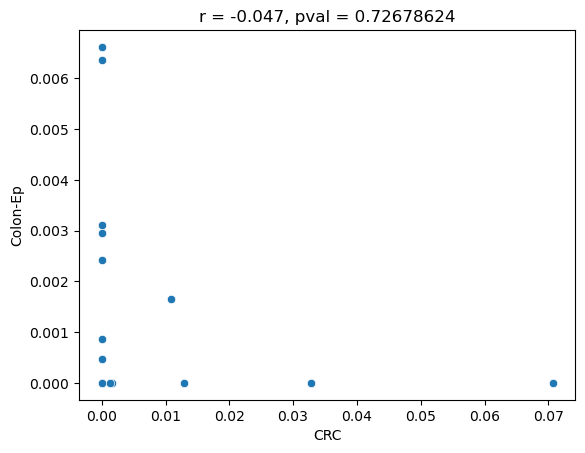

In [67]:
group1 = "CRC"
group2 = "Colon-Ep"
x = joindf[group1].to_numpy()
y = joindf[group2].to_numpy()
r = scipy.stats.pearsonr(x, y)

sns.scatterplot(data = joindf, x = group1, y = group2)
plt.title("r = {:.3f}, pval = {:.8f}".format(r.correlation, r.pvalue))
plt.show()

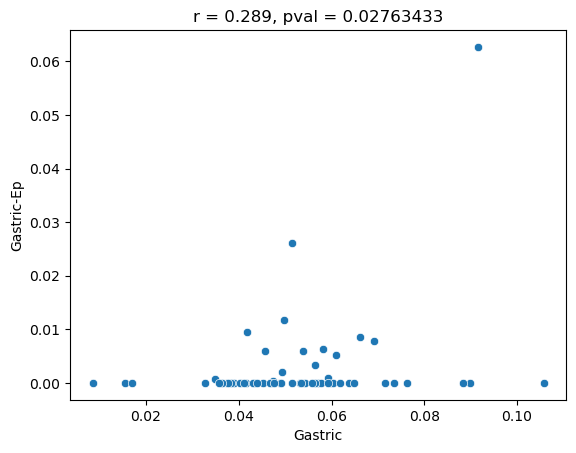

In [68]:
group1 = "Gastric"
group2 = "Gastric-Ep"
x = joindf[group1].to_numpy()
y = joindf[group2].to_numpy()
r = scipy.stats.pearsonr(x, y)

sns.scatterplot(data = joindf, x = group1, y = group2)
plt.title("r = {:.3f}, pval = {:.8f}".format(r.correlation, r.pvalue))
plt.show()

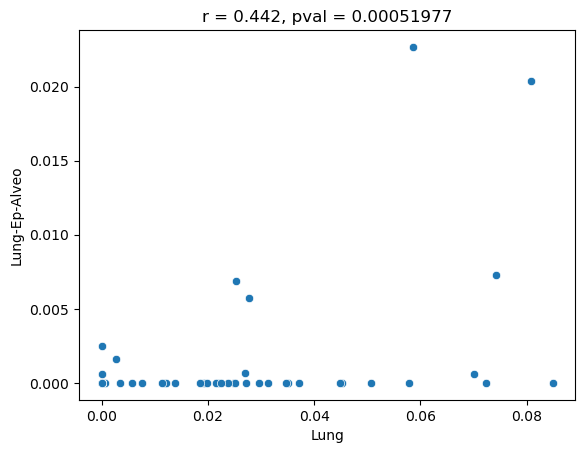

In [69]:
group1 = "Lung"
group2 = "Lung-Ep-Alveo"
x = joindf[group1].to_numpy()
y = joindf[group2].to_numpy()
r = scipy.stats.pearsonr(x, y)

sns.scatterplot(data = joindf, x = group1, y = group2)
plt.title("r = {:.3f}, pval = {:.8f}".format(r.correlation, r.pvalue))
plt.show()

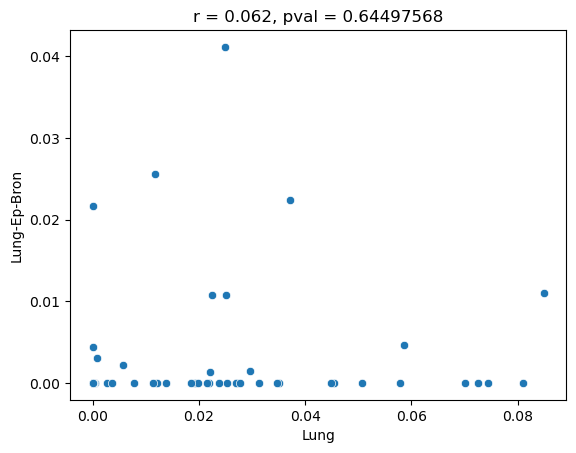

In [70]:
group1 = "Lung"
group2 = 'Lung-Ep-Bron'
x = joindf[group1].to_numpy()
y = joindf[group2].to_numpy()
r = scipy.stats.pearsonr(x, y)

sns.scatterplot(data = joindf, x = group1, y = group2)
plt.title("r = {:.3f}, pval = {:.8f}".format(r.correlation, r.pvalue))
plt.show()

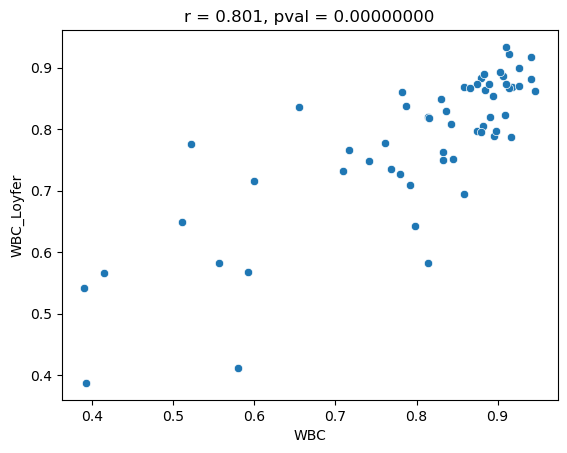

In [71]:
group1 = "WBC"
group2 = 'WBC_Loyfer'
x = joindf[group1].to_numpy()
y = joindf[group2].to_numpy()
r = scipy.stats.pearsonr(x, y)

sns.scatterplot(data = joindf, x = group1, y = group2)
plt.title("r = {:.3f}, pval = {:.8f}".format(r.correlation, r.pvalue))
plt.show()

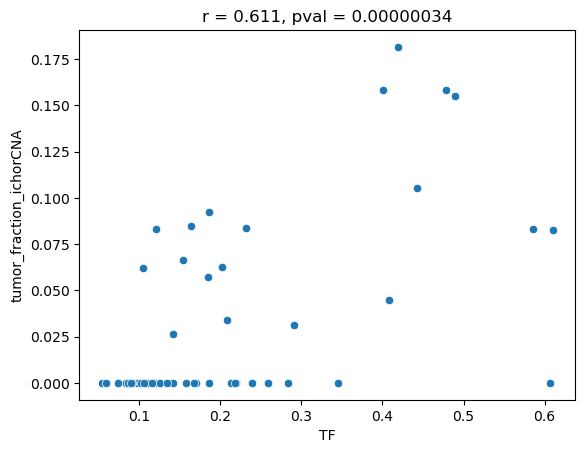

In [74]:
joindf["TF"] = joindf["WBC"].apply(lambda x: 1-x)
group1 = "TF"
group2 = 'tumor_fraction_ichorCNA'
x = joindf[group1].to_numpy()
y = joindf[group2].to_numpy()
r = scipy.stats.pearsonr(x, y)

sns.scatterplot(data = joindf, x = group1, y = group2)
plt.title("r = {:.3f}, pval = {:.8f}".format(r.correlation, r.pvalue))
plt.show()